In [1]:
import os
import warnings
import pprint

import xarray as xr
import numpy as np
import toml
import torch
from scipy.ndimage import gaussian_filter, gaussian_filter1d

import libVoodoo.TorchModel as TM

import matplotlib
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

NCLASSES = 3
p = 0.8


In [2]:
def VoodooPredictor(X):
    model_setup_file = f'VnetSettings-1.toml'
    torch_settings = toml.load(os.path.join(model_setup_file))['pytorch']
    torch_settings.update({'dev': 'cpu'})
    #trained_model = 'Vnet0x60de1687-fnX-gpu0-VN.pt'
    trained_model = 'Vnet0x615580bf-fn1-gpu0-VN.pt' #new

    print(f'Loading Vnet model ...... {model_setup_file}')

    # (n_samples, n_Doppler_bins, n_time_steps)
    X = X[:, :, :, np.newaxis]
    X = X.transpose(0, 3, 2, 1)
    X_test = torch.Tensor(X)

    model = TM.VoodooNet(X_test.shape, NCLASSES, **torch_settings)
    model.load_state_dict(torch.load(trained_model, map_location=model.device)['state_dict'])

    prediction = model.predict(X_test, batch_size=256)
    prediction = prediction.to('cpu')
    return prediction

In [3]:
data_path = 'sample_data/nsakazrspeccmaskgecopolC1.a0.20190127.040010.cdf'

data = xr.open_mfdataset(data_path)

#data = data.sel(range=slice(0, 6000))
#data['time'] = data['time_offset']
data['time'] = data['time_offset'].values + np.timedelta64(4,'h')
data

<xarray.Dataset>
Dimensions:        (numspectra: 70362, range: 582, speclength: 256, time: 973)
Coordinates:
  * range          (range) float32 100.679245 130.6585 ... 17488.643 17518.621
  * time           (time) datetime64[ns] 2019-01-27T04:00:00.383383035 ... 2019-01-27T04:59:51.526254892
Dimensions without coordinates: numspectra, speclength
Data variables:
    base_time      datetime64[ns] ...
    time_offset    (time) datetime64[ns] dask.array<shape=(973,), chunksize=(973,)>
    velocity_bins  (speclength) float32 dask.array<shape=(256,), chunksize=(256,)>
    locator_mask   (time, range) float64 dask.array<shape=(973, 582), chunksize=(973, 582)>
    spectra        (numspectra, speclength) float32 dask.array<shape=(70362, 256), chunksize=(70362, 256)>
Attributes:
    antenna_altitude:            3.66 m
    antenna_diameter:            1.810 m
    attenuation:                 4.00 dB
    cal_constant:                -13.9600 dB
    clutter_filter_len:          0
    fft_len:      

In [4]:
hsrl = xr.open_mfdataset('sample_data/nsahsrlC1.a1.20190127.000000.nc')

#hsrl = hsrl.sel(time=slice(data['time_offset'][0].values, data['time_offset'][-1].values))
backscatter = hsrl['beta_a_backscatter']
depol = hsrl['depol']

In [5]:
data['time_offset'].values + np.timedelta64(4,'h')

array(['2019-01-27T04:00:00.383383035', '2019-01-27T04:00:04.077981948',
       '2019-01-27T04:00:07.772571086', '2019-01-27T04:00:11.467163085',
       '2019-01-27T04:00:15.161746025', '2019-01-27T04:00:18.856343030',
       '2019-01-27T04:00:22.550932884', '2019-01-27T04:00:26.245531082',
       '2019-01-27T04:00:29.940115928', '2019-01-27T04:00:33.634712934',
       '2019-01-27T04:00:37.329297065', '2019-01-27T04:00:41.023890018',
       '2019-01-27T04:00:44.718482971', '2019-01-27T04:00:48.413077116',
       '2019-01-27T04:00:52.107661962', '2019-01-27T04:00:55.802253961',
       '2019-01-27T04:00:59.496850967', '2019-01-27T04:01:03.191438913',
       '2019-01-27T04:01:06.886033058', '2019-01-27T04:01:10.580627918',
       '2019-01-27T04:01:14.275216102', '2019-01-27T04:01:17.969806909',
       '2019-01-27T04:01:21.664400100', '2019-01-27T04:01:25.358983993',
       '2019-01-27T04:01:29.053582906', '2019-01-27T04:01:32.748174905',
       '2019-01-27T04:01:36.442764997', '2019-01-27

In [6]:
data['base_time'].values

numpy.datetime64('2019-01-27T04:00:06.000000000')

In [7]:
hsrl

<xarray.Dataset>
Dimensions:                   (cal_time: 25, range: 667, time: 2880, time_vector: 8)
Coordinates:
  * time                      (time) datetime64[ns] 2019-01-27 ... 2019-01-27T23:59:30
  * range                     (range) float32 0.0 30.0 60.0 ... 19950.0 19980.0
  * cal_time                  (cal_time) datetime64[ns] 2019-01-27 ... 2019-01-27T23:30:00
Dimensions without coordinates: time_vector
Data variables:
    base_time                 datetime64[ns] ...
    time_offset               (time) datetime64[ns] dask.array<shape=(2880,), chunksize=(2880,)>
    cal_time_vector           (cal_time, time_vector) int16 dask.array<shape=(25, 8), chunksize=(25, 8)>
    time_average              float32 ...
    range_resolution          float32 ...
    cal_trigger               (cal_time) int16 dask.array<shape=(25,), chunksize=(25,)>
    top_alt_sounding          (cal_time) float32 dask.array<shape=(25,), chunksize=(25,)>
    temperature_profile       (cal_time, range) float3

In [8]:
# show quicklook 
%matplotlib inline

In [9]:
# get nonzero mask
nonzeros_mask = data['locator_mask'].values > -1

-100.31966 -44.569817
-0.009133039 1.5837195


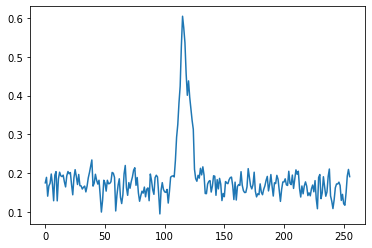

In [10]:
# show spectra quicklook + normalize
spectra_orig = data['spectra'].values.copy()
#spectra_orig = gaussian_filter1d(data['spectra'].values.copy(), sigma=2)

print(spectra_orig.min(), spectra_orig.max())

# normalize between 0 and 1

v_min = -100
v_max = -65
spectra_norm = (spectra_orig - v_min) / (v_max - v_min)
plt.plot(spectra_norm[1000, :])

print(spectra_norm.min(), spectra_norm.max())

In [11]:
X = np.zeros((spectra_norm.shape)+(6,))
for i in range(spectra_norm.shape[0]):
    for j in range(6):
        X[i, :, j] = spectra_norm[i, :]

In [12]:
prediction = VoodooPredictor(X)

Loading Vnet model ...... VnetSettings-1.toml


In [13]:
prediction_smoothed = np.zeros((nonzeros_mask.shape)+(3,))
for i in range(NCLASSES):
    _tmp = TM.VoodooNet.reshape(prediction[:, i], ~nonzeros_mask)
    _tmp = gaussian_filter(_tmp, sigma=1)
    prediction_smoothed[:, :, i] = np.ma.masked_where(~nonzeros_mask, _tmp)
    


In [14]:
# compute fake Z (sum of spectra)
fake_Z = TM.VoodooNet.reshape3d(data['spectra'].values, ~nonzeros_mask)
fake_Z = np.ma.masked_where(~nonzeros_mask, np.sum(10**(fake_Z/10), axis=2)).T
fake_Z = 10*np.log10(fake_Z)
print(fake_Z.min(), fake_Z.max())

-70.221598723326 -34.827239509821595


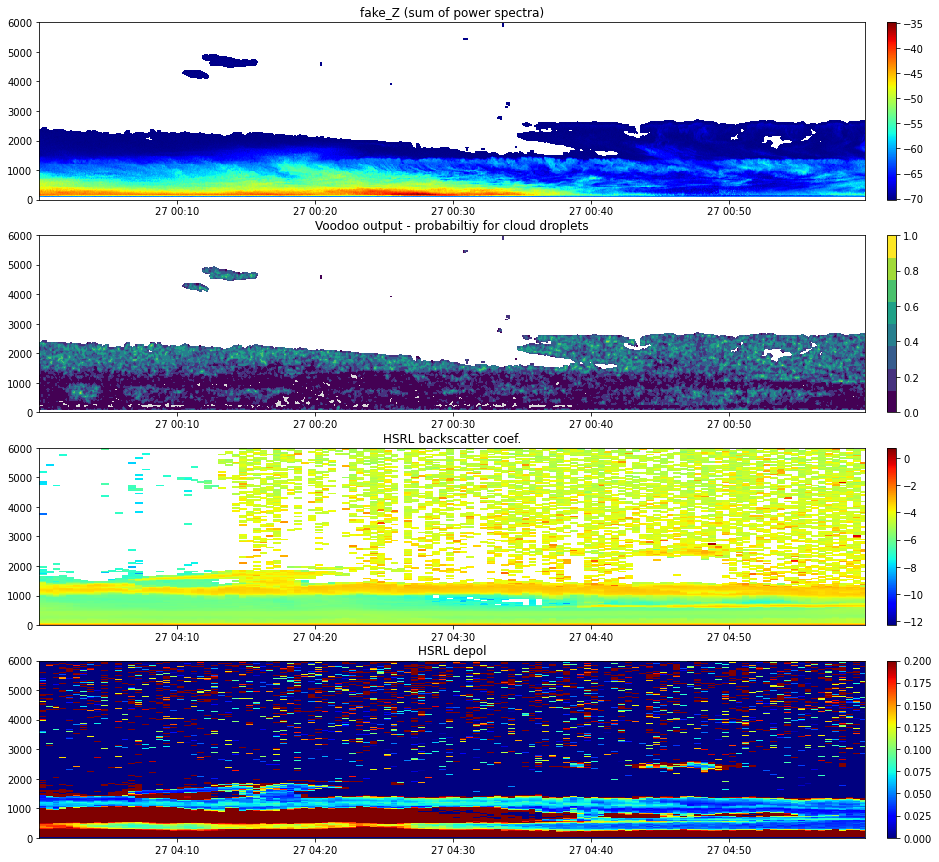

In [19]:

# VOODOO cloud droplet likelyhood colorbar (viridis + grey below minimum value)
from matplotlib import cm
from matplotlib.colors import ListedColormap
viridis = cm.get_cmap('viridis', 8)
newcolors = viridis(np.linspace(0, 1, 256))
newcolors[:1, :] = np.array([220/256, 220/256, 220/256, 1])


fig, ax = plt.subplots(nrows=4, figsize=(16, 15))

# fake Z
pcmesh = ax[0].pcolormesh(
    data['time_offset'].values,
    data['range'].values,    
    fake_Z,
    cmap='jet',
    vmin=fake_Z.min(), vmax=fake_Z.max(),
)
cbar = fig.colorbar(pcmesh, ax=ax[0], fraction=0.05, pad=0.025)    
ax[0].set_title('fake_Z (sum of power spectra)')
ax[0].set_ylim([0,6000])

# probability for liquid cloud droplets
pcmesh = ax[1].pcolormesh(
    data['time_offset'].values,
    data['range'].values,    
    np.ma.masked_where(~nonzeros_mask, prediction_smoothed[:, :, 2]).T, 
    cmap=ListedColormap(newcolors), 
    vmin=0, vmax=1
)
cbar = fig.colorbar(pcmesh, ax=ax[1], fraction=0.05, pad=0.025)    
ax[1].set_title('Voodoo output - probabiltiy for cloud droplets')
ax[1].set_ylim([0,6000])

# hsrl backscatter
pcmesh = ax[2].pcolormesh(
    backscatter['time'].values,
    backscatter['range'].values,    
    np.log10(backscatter.values).T, 
    cmap='jet', 
    #vmin=0.9, vmax=1
)
cbar = fig.colorbar(pcmesh, ax=ax[2], fraction=0.05, pad=0.025)    
ax[2].set_title('HSRL backscatter coef.')

# hsrl depol
pcmesh = ax[3].pcolormesh(
    depol['time'].values,
    depol['range'].values,    
    depol.values.T, 
    cmap='jet', 
    vmin=0., vmax=0.2
)
cbar = fig.colorbar(pcmesh, ax=ax[3], fraction=0.05, pad=0.025)    
ax[3].set_title('HSRL depol')


for iax in ax[2:]:
    iax.set_ylim([0,6000])
    iax.set_xlim([data['time'][0].values, data['time'][-1].values])
    
fig.savefig('test.png', facecolor='white')

In [16]:
depol['range']

<xarray.DataArray 'range' (range: 667)>
array([    0.,    30.,    60., ..., 19920., 19950., 19980.], dtype=float32)
Coordinates:
  * range    (range) float32 0.0 30.0 60.0 90.0 ... 19920.0 19950.0 19980.0
Attributes:
    long_name:  Height above lidar
    units:      m

In [17]:


data['range'].values

array([  100.679245,   130.6585  ,   160.63774 ,   190.61699 ,
         220.59622 ,   250.57547 ,   280.55472 ,   310.53397 ,
         340.5132  ,   370.49246 ,   400.4717  ,   430.45096 ,
         460.4302  ,   490.40945 ,   520.3887  ,   550.3679  ,
         580.34717 ,   610.3264  ,   640.30566 ,   670.2849  ,
         700.26416 ,   730.2434  ,   760.22266 ,   790.2019  ,
         820.18115 ,   850.1604  ,   880.13965 ,   910.1189  ,
         940.09814 ,   970.0774  ,  1000.05664 ,  1030.0359  ,
        1060.0151  ,  1089.9944  ,  1119.9736  ,  1149.9529  ,
        1179.9321  ,  1209.9114  ,  1239.8906  ,  1269.8699  ,
        1299.8491  ,  1329.8284  ,  1359.8076  ,  1389.7869  ,
        1419.7661  ,  1449.7454  ,  1479.7246  ,  1509.7039  ,
        1539.683   ,  1569.6622  ,  1599.6415  ,  1629.6207  ,
        1659.6     ,  1689.5792  ,  1719.5585  ,  1749.5377  ,
        1779.517   ,  1809.4962  ,  1839.4755  ,  1869.4547  ,
        1899.434   ,  1929.4132  ,  1959.3925  ,  1989.